# Unsupervised graph classification/representation learning via distances
From: https://stellargraph.readthedocs.io/en/stable/demos/embeddings/gcn-unsupervised-graph-embeddings.html

## Imports

In [1]:
import stellargraph as sg
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow import keras

from IPython.display import display, HTML

from sklearn.linear_model import LogisticRegression
from sklearn import model_selection

2021-10-27 12:32:01.268393: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2021-10-27 12:32:01.268423: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kontor
2021-10-27 12:32:01.268427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kontor
2021-10-27 12:32:01.268505: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.63.1
2021-10-27 12:32:01.268524: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.63.1
2021-10-27 12:32:01.268528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.63.1
2021-10-27 12:32:01.268785: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operat

# Load Dataset

In [2]:
dataset = sg.datasets.PROTEINS()
display(HTML(dataset.description))
graphs, graph_labels = dataset.load()

graph_labels.value_counts().to_frame()

print(graphs[0].info())

StellarGraph: Undirected multigraph
 Nodes: 42, Edges: 162

 Node types:
  default: [42]
    Features: float32 vector, length 4
    Edge types: default-default->default

 Edge types:
    default-default->default: [162]
        Weights: all 1 (default)
        Features: none


# General Stats

In [3]:
summary = pd.DataFrame(
    [(g.number_of_nodes(), g.number_of_edges()) for g in graphs],
    columns=["nodes", "edges"],
)
summary.describe().round(1)

,nodes,edges
count,1113.0,1113.0
mean,39.1,145.6
std,45.8,169.3
min,4.0,10.0
25%,15.0,56.0
50%,26.0,98.0
75%,45.0,174.0
max,620.0,2098.0


# Create the model

In [4]:
generator = sg.mapper.PaddedGraphGenerator(graphs)

gc_model = sg.layer.GCNSupervisedGraphClassification(
    [64, 32], ["relu", "relu"], generator, pool_all_layers=True
)

inp1, out1 = gc_model.in_out_tensors()
inp2, out2 = gc_model.in_out_tensors()

vec_distance = tf.norm(out1 - out2, axis=1)

pair_model = keras.Model(inp1 + inp2, vec_distance)
embedding_model = keras.Model(inp1, out1)

### Graph distance

In [5]:
def graph_distance(graph1, graph2):
    spec1 = nx.laplacian_spectrum(graph1.to_networkx(feature_attr=None))
    spec2 = nx.laplacian_spectrum(graph2.to_networkx(feature_attr=None))
    k = min(len(spec1), len(spec2))
    return np.linalg.norm(spec1[:k] - spec2[:k])

## Training examples

In [6]:
graph_idx = np.random.RandomState(0).randint(len(graphs), size=(100, 2))

targets = [graph_distance(graphs[left], graphs[right]) for left, right in graph_idx]

train_gen = generator.flow(graph_idx, batch_size=10, targets=targets)


# Training procedure


In [7]:
pair_model.compile(keras.optimizers.Adam(1e-2), loss="mse")

UsageError: Line magic function `%%time` not found.


2021-10-27 12:32:29.003686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 1min 56s, sys: 12.7 s, total: 2min 9s
Wall time: 42.7 s


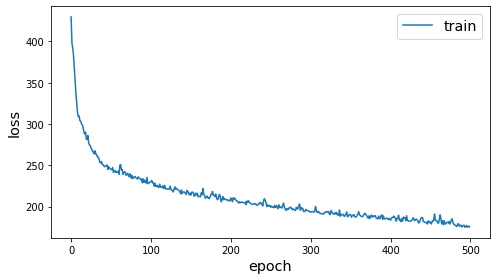

In [8]:
%%time
history = pair_model.fit(train_gen, epochs=500, verbose=0)
sg.utils.plot_history(history)

## Compute embeddings


In [9]:
embeddings = embedding_model.predict(generator.flow(graphs))

# Supervised graph classification


In [10]:
train_labels, test_labels = model_selection.train_test_split(
    graph_labels, train_size=0.1, test_size=None, stratify=graph_labels
)

test_embeddings = embeddings[test_labels.index - 1]
train_embeddings = embeddings[train_labels.index - 1]

lr = LogisticRegression(multi_class="auto", solver="lbfgs")
lr.fit(train_embeddings, train_labels)

y_pred = lr.predict(test_embeddings)
gcn_acc = (y_pred == test_labels).mean()
print(f"Test classification accuracy: {gcn_acc}")

Test classification accuracy: 0.654690618762475


/home/eholden/.pyenv/versions/3.7.5/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [11]:
pd.crosstab(test_labels, y_pred, rownames=["true"], colnames=["predicted"])

predicted,1,2
true,,
1,481,116
2,230,175


# Visualising embeddings


In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(2)
two_d = tsne.fit_transform(embeddings)

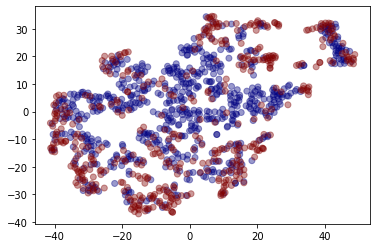

In [13]:
from matplotlib import pyplot as plt

plt.scatter(two_d[:, 0], two_d[:, 1], c=graph_labels.cat.codes, cmap="jet", alpha=0.4)